I use settings and pre-processing from from kaggle -https://www.kaggle.com/paoloripamonti/twitter-sentiment-analysis  
The intention here to skip to building models and compare models with other than build on the kernel


In [1]:
import json

# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

#Seaborn
import seaborn as sns
sns.set()

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.multiclass import unique_labels

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM,GRU
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import SGD,Adam

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/mars/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [4]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

# dataset downloaded from kaggle : https://www.kaggle.com/kazanova/sentiment140
df = pd.read_csv('../data/tweets_processed.csv',encoding =DATASET_ENCODING, names=DATASET_COLUMNS)

In [5]:
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df.shape

(1600000, 6)

In [7]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))


CPU times: user 354 ms, sys: 19.6 ms, total: 373 ms
Wall time: 374 ms


In [9]:
df.target.unique()

array(['NEGATIVE', 'POSITIVE'], dtype=object)

In [10]:
df.groupby('target')['text'].nunique().values

array([790185, 793506])

Text(0.5, 1.0, 'Dataset labels distribuition')

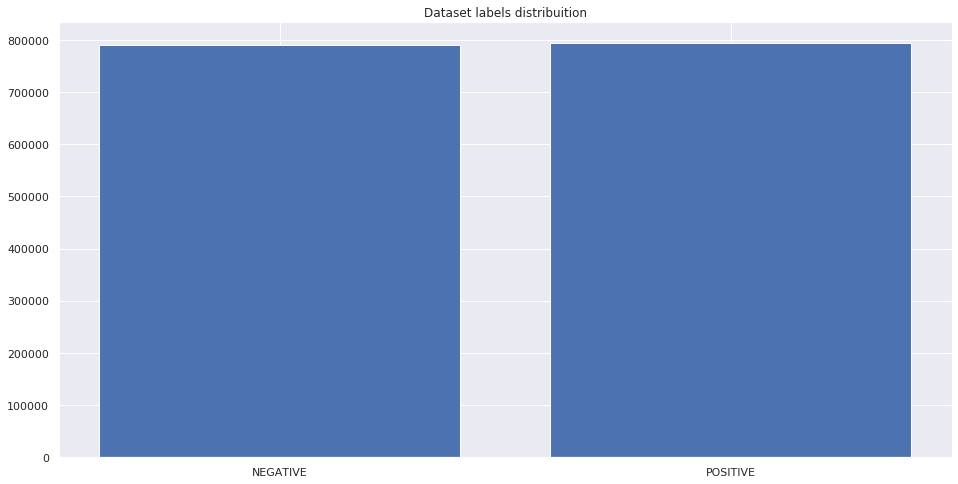

In [11]:
plt.figure(figsize=(16,8))
plt.bar(df.target.unique(),df.groupby('target')['text'].nunique().values)
plt.title("Dataset labels distribuition")

In [12]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [13]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 33.1 s, sys: 54.1 ms, total: 33.2 s
Wall time: 33.2 s


In [15]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42, shuffle=True)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [16]:
%%time
documents = [_text.split() for _text in df_train.text]
# documents = [_text.split() for _text in df.text]

CPU times: user 1.39 s, sys: 164 ms, total: 1.55 s
Wall time: 1.55 s


In [17]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [18]:
len(documents)

1280000

In [19]:
w2v_model.build_vocab(documents)

2019-11-10 05:12:51,248 : INFO : collecting all words and their counts
2019-11-10 05:12:51,249 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-11-10 05:12:51,265 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2019-11-10 05:12:51,280 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2019-11-10 05:12:51,296 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2019-11-10 05:12:51,313 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2019-11-10 05:12:51,327 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2019-11-10 05:12:51,339 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2019-11-10 05:12:51,354 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2019-11-10 05:12:51,368 : INFO : PROGRESS: at s

2019-11-10 05:12:52,426 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2019-11-10 05:12:52,445 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2019-11-10 05:12:52,463 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2019-11-10 05:12:52,482 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2019-11-10 05:12:52,499 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2019-11-10 05:12:52,515 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2019-11-10 05:12:52,529 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2019-11-10 05:12:52,545 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2019-11-10 05:12:52,564 : INFO : PROGRESS: at sentence #800000, processed 577088

In [20]:
w2v_model.most_similar("awesome")

/home/mars/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-11-10 05:12:57,871 : INFO : precomputing L2-norms of word weight vectors


[('helicopters', 0.24855685234069824),
 ('upped', 0.2220427393913269),
 ('lyrical', 0.22003287076950073),
 ('waaaay', 0.21733635663986206),
 ('jsyk', 0.2155488133430481),
 ('gargle', 0.21070939302444458),
 ('sunglasses', 0.20617534220218658),
 ('babby', 0.20425865054130554),
 ('making', 0.20073765516281128),
 ('kerri', 0.19851389527320862)]

In [21]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 12.9 s, sys: 51.7 ms, total: 13 s
Wall time: 13 s


In [22]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 17.5 s, sys: 180 ms, total: 17.7 s
Wall time: 17.7 s


In [23]:
labels = ['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [24]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [25]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [26]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [27]:
    
embedding_matrix[2].sum()

0.0034942353436235862

In [28]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

## Modelling

In [29]:
model = {}

In [30]:
model['lstm'] = Sequential()
model['lstm'].add(embedding_layer)
model['lstm'].add(Dropout(0.5))
model['lstm'].add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model['lstm'].add(Dense(1, activation='sigmoid'))
model['lstm'].compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])

model['lstm'].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [31]:
model['gru'] = Sequential()
model['gru'].add(embedding_layer)
model['gru'].add(Dropout(0.5))
model['gru'].add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
model['gru'].add(Dense(1, activation='sigmoid'))
model['gru'].compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.01),
              metrics=['accuracy'])

model['gru'].summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               120300    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 87,246,101
Trainable params: 120,401
Non-trainable params: 87,125,700
_________________________________________________________________


In [32]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [33]:
history = {}

In [37]:
%%time
history['lstm'] = model['lstm'].fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 422s 366us/step - loss: 0.6955 - accuracy: 0.5046 - val_loss: 0.6930 - val_accuracy: 0.5002
Epoch 2/8
1152000/1152000 [==============================] - 422s 366us/step - loss: 0.6943 - accuracy: 0.5013 - val_loss: 0.6945 - val_accuracy: 0.4999
Epoch 3/8
1152000/1152000 [==============================] - 422s 366us/step - loss: 0.6940 - accuracy: 0.5018 - val_loss: 0.6934 - val_accuracy: 0.5001
Epoch 4/8
1152000/1152000 [==============================] - 422s 366us/step - loss: 0.6938 - accuracy: 0.5062 - val_loss: 0.6911 - val_accuracy: 0.5522
Epoch 5/8
1152000/1152000 [==============================] - 421s 365us/step - loss: 0.6927 - accuracy: 0.5151 - val_loss: 0.6890 - val_accuracy: 0.5533
Epoch 6/8
1152000/1152000 [==============================] - 421s 366us/step - loss: 0.6916 - accuracy: 0.5225 - val_loss: 0.6865 - val_accuracy: 0.5662
Epoch 7/8
1152000/1152000 [==

In [34]:
%%time
history['gru'] = model['gru'].fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 408s 355us/step - loss: 9963399558777431654400.0000 - accuracy: 0.5717 - val_loss: 0.6569 - val_accuracy: 0.6189
Epoch 2/8


/home/mars/.local/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


1152000/1152000 [==============================] - 405s 351us/step - loss: 17402708718325862498304.0000 - accuracy: 0.5911 - val_loss: 0.6524 - val_accuracy: 0.6228
Epoch 3/8
1152000/1152000 [==============================] - 405s 351us/step - loss: 17789062742647205003264.0000 - accuracy: 0.5966 - val_loss: 0.6488 - val_accuracy: 0.6279
Epoch 4/8
1152000/1152000 [==============================] - 405s 351us/step - loss: 16630680693122208366592.0000 - accuracy: 0.5988 - val_loss: 0.6465 - val_accuracy: 0.6291
Epoch 5/8
1152000/1152000 [==============================] - 404s 351us/step - loss: 13343201726809707118592.0000 - accuracy: 0.6020 - val_loss: 0.6434 - val_accuracy: 0.6350
Epoch 6/8
1152000/1152000 [==============================] - 403s 350us/step - loss: 16039304698713459392512.0000 - accuracy: 0.6051 - val_loss: 0.6435 - val_accuracy: 0.6273
Epoch 7/8
1152000/1152000 [==============================] - 405s 352us/step - loss: 21776189920095101779968.0000 - accuracy: 0.6083 - 

In [38]:
%%time
lstm_score = model['lstm'].evaluate(x_test, y_test, batch_size=BATCH_SIZE) 
gru_score = model['gru'].evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print("ACCURACY")
print("LSTM:",lstm_score[1])
print("GRU:",gru_score[1])

print("LOSS")
print("LSTM:",lstm_score[0])
print("GRU:",gru_score[0])

320000/320000 [==============================] - 41s 127us/step
ACCURACY
LSTM: 0.5585562586784363
GRU: 0.6336531043052673
LOSS
LSTM: 0.6841224783897399
GRU: 0.6375676298141479
CPU times: user 1min 33s, sys: 3.99 s, total: 1min 37s
Wall time: 1min 26s


In [40]:
epochs = range(len(history['lstm'].history['accuracy'])) 

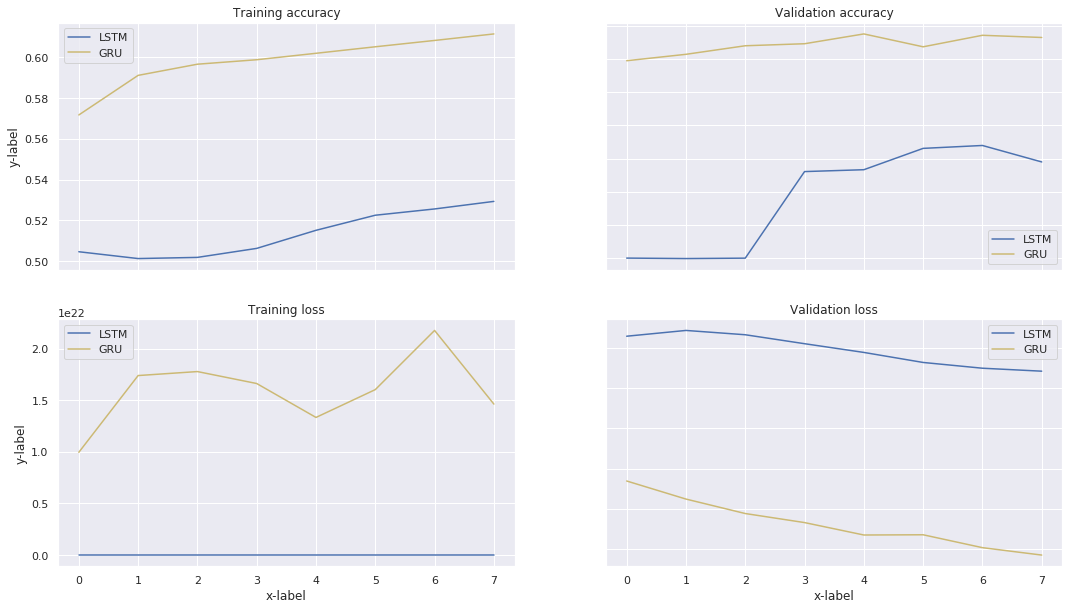

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(18,10))

axs[0, 0].set_title('Training accuracy')
axs[0, 0].plot(epochs, history['lstm'].history['accuracy'], 'b', label='LSTM')
axs[0, 0].plot(epochs, history['gru'].history['accuracy'], 'y', label='GRU')
axs[0, 0].legend()

axs[0, 1].set_title('Validation accuracy')
axs[0, 1].plot(epochs, history['lstm'].history['val_accuracy'], 'b', label='LSTM')
axs[0, 1].plot(epochs, history['gru'].history['val_accuracy'], 'y', label='GRU')
axs[0, 1].legend()

axs[1, 0].set_title('Training loss')
axs[1, 0].plot(epochs, history['lstm'].history['loss'], 'b', label='LSTM')
axs[1, 0].plot(epochs, history['gru'].history['loss'], 'y', label='GRU')
axs[1, 0].legend()

axs[1, 1].set_title('Validation loss')
axs[1, 1].plot(epochs, history['lstm'].history['val_loss'], 'b', label='LSTM')
axs[1, 1].plot(epochs, history['gru'].history['val_loss'], 'y', label='GRU')
axs[1, 1].legend()

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.show()

In [55]:
model['lstm'].save_weights('../data/nlp_lstm.h5')
model['gru'].save_weights('../data/nlp_gru.h5')

In [56]:
with open('../data/lstm_history', 'wb') as file_pi:
        pickle.dump(history['lstm'].history, file_pi)

with open('../data/gru_history', 'wb') as file_pi:
        pickle.dump(history['gru'].history, file_pi)

In [57]:
w2v_model.save('../data/w2v_tweet.w2v')

2019-11-09 22:18:22,176 : INFO : saving Word2Vec object under ../data/w2v_tweet.w2v, separately None
2019-11-09 22:18:22,179 : INFO : not storing attribute vectors_norm
2019-11-09 22:18:22,181 : INFO : not storing attribute cum_table
2019-11-09 22:18:22,583 : INFO : saved ../data/w2v_tweet.w2v


In [58]:
pickle.dump(tokenizer, open('../data/tokennizer.pkl', "wb"), protocol=0)
pickle.dump(encoder, open('../data/encoder.pkl', "wb"), protocol=0)

In [61]:
with open('../data/lstm_history', "rb")as file:
    test = pickle.load(file)
    


In [33]:
model['lstm'].load_weights("../data/nlp_lstm.h5")
model['gru'].load_weights("../data/nlp_gru.h5")

# Prediction

In [34]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE
    
def predict(text, include_neutral=True, model_type="gru"):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model[model_type].predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [35]:
predict("Emma love Ammar Syatbi")

{'label': 'POSITIVE',
 'score': 0.7417604923248291,
 'elapsed_time': 0.3377361297607422}

In [36]:
%%time
gru_pred = []
gru_test = list(df_test.target)
scores = model['gru'].predict(x_test, verbose=1, batch_size=2000)
gru_pred = [decode_sentiment(score, include_neutral=False) for score in scores]

320000/320000 [==============================] - 41s 127us/step
CPU times: user 49.3 s, sys: 2.96 s, total: 52.3 s
Wall time: 41.1 s


[[0.45 0.55]
 [0.18 0.82]]


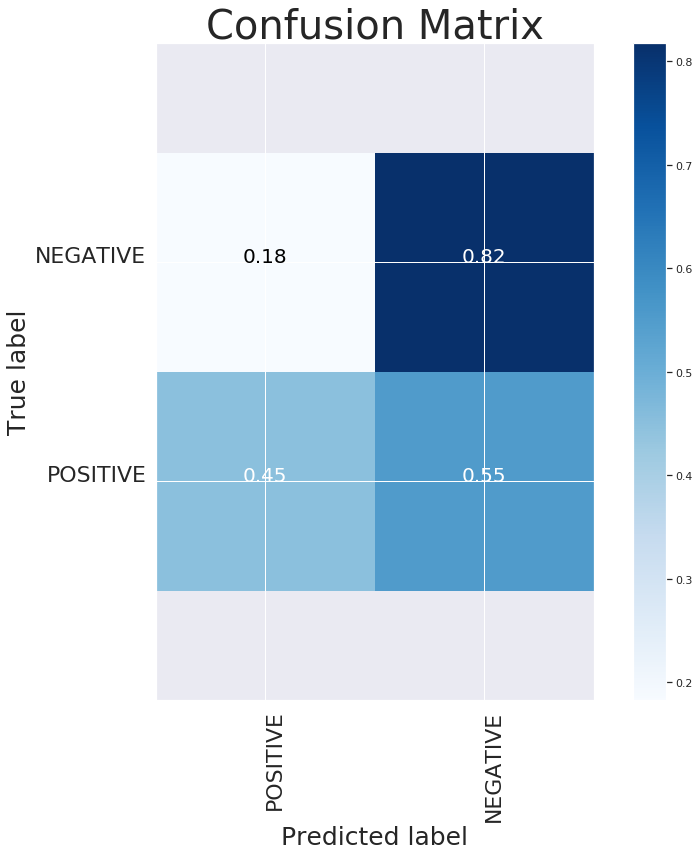

In [37]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    fig, ax = plt.subplots(figsize=(12,12))
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set_xticks(ticks=np.arange(cm.shape[1]))
    ax.set_xticklabels(labels=classes, fontsize=22)
    ax.set_yticks(ticks=np.arange(cm.shape[0]))
    ax.set_yticklabels(labels=classes, fontsize=22, verticalalignment='baseline')
    ax.set_ylim(-1, 2)
    ax.set_title(label=title, fontsize=40)
    
    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i, format(cm[i, j], fmt),
                    fontsize=20,
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plot_confusion_matrix(gru_test, gru_pred, classes=df_train.target.unique(),
                      title='Confusion Matrix')



In [39]:
print(classification_report(gru_test, gru_pred))

              precision    recall  f1-score   support

    NEGATIVE       0.71      0.45      0.55    159494
    POSITIVE       0.60      0.82      0.69    160506

    accuracy                           0.63    320000
   macro avg       0.65      0.63      0.62    320000
weighted avg       0.65      0.63      0.62    320000



In [40]:
accuracy_score(gru_test, gru_pred)

0.633653125